__Imports__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import tensorflow_datasets as tfds

### Load in the data__
* Splits the data
* Shuffle the data

__Batch_size=-1 to get the full dataset in NumPy arrays from the returned tf.Tensor object__

In [2]:
mnist_test,mnist_val,mnist_train = tfds.load(name="mnist",
                                             split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
                                             batch_size=-1,
                                             shuffle_files=True
                                            ) 

__tfds.as_numpy return a generator that yields NumPy array records out of a tf.data.Dataset__

In [3]:
# tfds.as_numpy return a generator that yields NumPy array records out of a tf.data.Dataset
mnist_train = tfds.as_numpy(mnist_train) 
mnist_val = tfds.as_numpy(mnist_val) 
mnist_test = tfds.as_numpy(mnist_test)

__Seperate the x and y__

In [4]:
x_train, y_train = mnist_train["image"], mnist_train["label"]
x_valid,y_valid = mnist_val["image"], mnist_val["label"]
x_test, y_test = mnist_test["image"], mnist_test["label"]

__Check lengths__

In [5]:
print("Train set size: ", len(x_train))
print("Valid set size: ", len(x_valid))
print("Test set size: ", len(x_test))

Train set size:  45000
Valid set size:  9000
Test set size:  6000


__Data Normalization__

In [6]:
# Normalize values
x_train = x_train/255
x_valid = x_valid/255
x_test = x_test/255

__Visualize the Data__

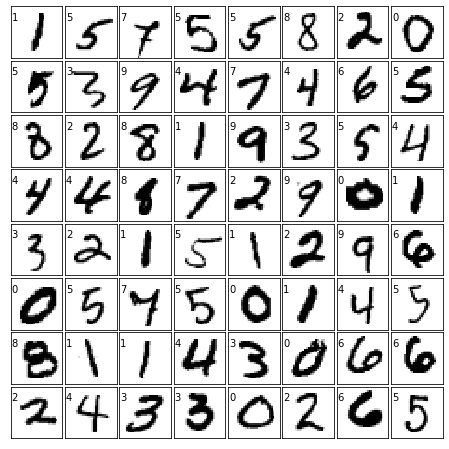

In [7]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y_train[i]))

### Processing Data

__Accuracy Function__

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

__Always a good habit to randomized seeds__

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

__Autoencoder Model__

__Encoder__

In [10]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D( filters=16, kernel_size=3, 
                        padding="SAME",
                        activation="selu" ),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D( filters=32, kernel_size=3, 
                        padding="SAME",
                        activation="selu" ),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D( filters=64, kernel_size=3, 
                        padding="SAME",
                        activation="selu" ),
    keras.layers.MaxPool2D(pool_size=2)
])
stacked_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

__Decoder__

In [11]:
stacked_decoder = keras.models.Sequential([
    # padding="VALID" since 3*2 !=7
    keras.layers.Conv2DTranspose( 32, kernel_size=3, 
                                 strides=2, padding="VALID",
                                 activation="selu", input_shape=[3,3,64]), #==> (None, 7, 7, 32)
    # 7x2 (strides)=14 and padding=0
    keras.layers.Conv2DTranspose( 16, kernel_size=3, strides=2, padding="SAME",
                                 activation="selu" ), #==> (None, 14, 14, 16)
    # 14x2(strides)=28
    keras.layers.Conv2DTranspose( 1, kernel_size=3, strides=2, padding="SAME", 
                                 activation="sigmoid" ), #==> (None, 28, 28, 1)
    keras.layers.Reshape([28,28])
])
stacked_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 7, 7, 32)         18464     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 16)       4624      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        145       
 ranspose)                                                       
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
__________________________________________________

__Now connect them together__

In [12]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

__Binary cross-entropy loss: each pixel(or each label) intensity represents the probability that the pixel should so model converges faster__

In [13]:
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=tf.keras.optimizers.SGD(learning_rate=1.5), 
                   metrics=[rounded_accuracy])

__Using x_train as both the inputs and the targets and similarly, we use x_valid as both the validation inputs and targets__


In [14]:
history = stacked_ae.fit(x_train, x_train,
                         epochs=20,
                         validation_data=(x_valid, x_valid))

Epoch 1/20
1407/1407 [==============================] - 8s 4ms/step - loss: 0.1095 - rounded_accuracy: 0.9618 - val_loss: 0.0867 - val_rounded_accuracy: 0.9739
Epoch 2/20
1407/1407 [==============================] - 5s 4ms/step - loss: 0.0817 - rounded_accuracy: 0.9775 - val_loss: 0.0817 - val_rounded_accuracy: 0.9775
Epoch 3/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.0775 - rounded_accuracy: 0.9804 - val_loss: 0.0766 - val_rounded_accuracy: 0.9810
Epoch 4/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.0752 - rounded_accuracy: 0.9820 - val_loss: 0.0758 - val_rounded_accuracy: 0.9813
Epoch 5/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.0738 - rounded_accuracy: 0.9831 - val_loss: 0.0746 - val_rounded_accuracy: 0.9826
Epoch 6/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.0728 - rounded_accuracy: 0.9838 - val_loss: 0.0742 - val_rounded_accuracy: 0.9825
Epoch 7/20
1407/1407 [==================

### Reconstruction Zone & Analysis

__Function to show plots__

In [15]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

__Function to Reconstruction Images given a model__

In [16]:
def show_reconstructions(model, images=x_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


__Top is Original & Bottom is Reconstructed__

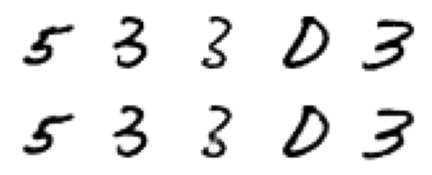

In [17]:
show_reconstructions(stacked_ae)

In [25]:
np.random.seed(42)
from sklearn.manifold import TSNE
X_valid_compressed = stacked_ae.predict(x_valid)
nsamples, nx, ny,oth = X_valid_compressed.shape
X_valid_compressed = X_valid_compressed.reshape((nsamples,nx*ny))

In [21]:
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

C:\Users\Michael\miniconda3\envs\py3_base\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Michael\miniconda3\envs\py3_base\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


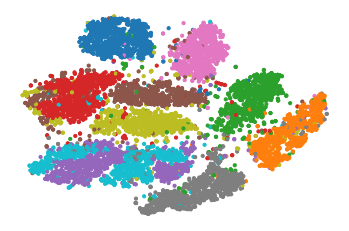

In [22]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

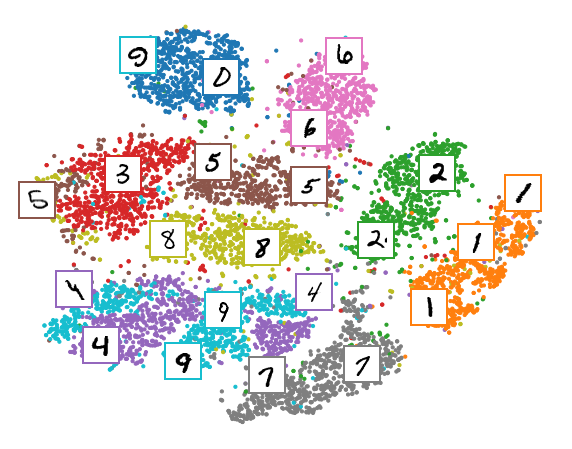

In [23]:
import matplotlib as mpl
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(x_valid[index], cmap="binary"),
                position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
    plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()
